In [593]:
# importing packages
import pyomo.environ as pyo
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.stats as stats
from scipy.optimize import fsolve, bisect
import pandas as pd

Conductivity of Simple Ionic Mixtures

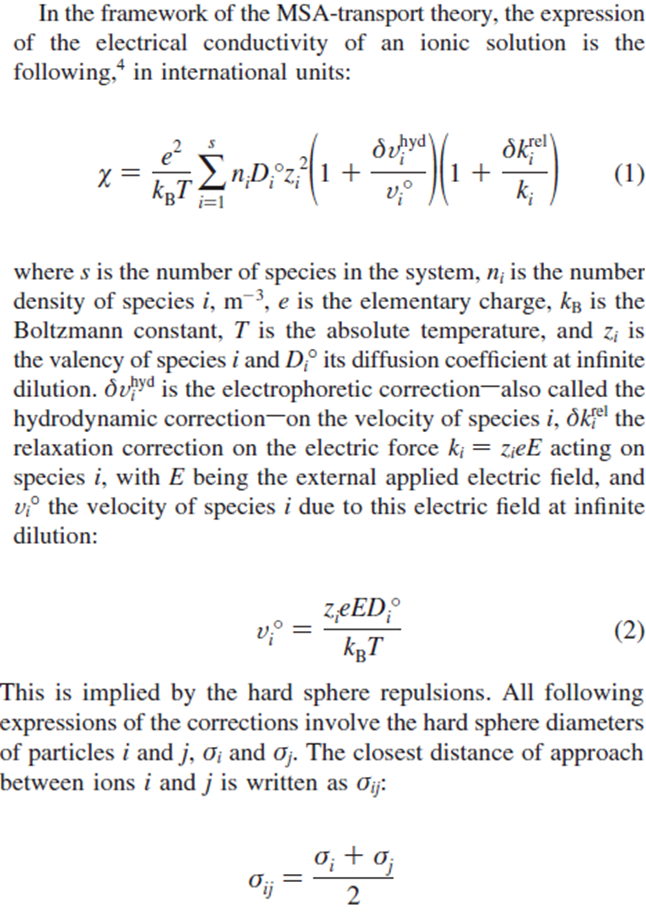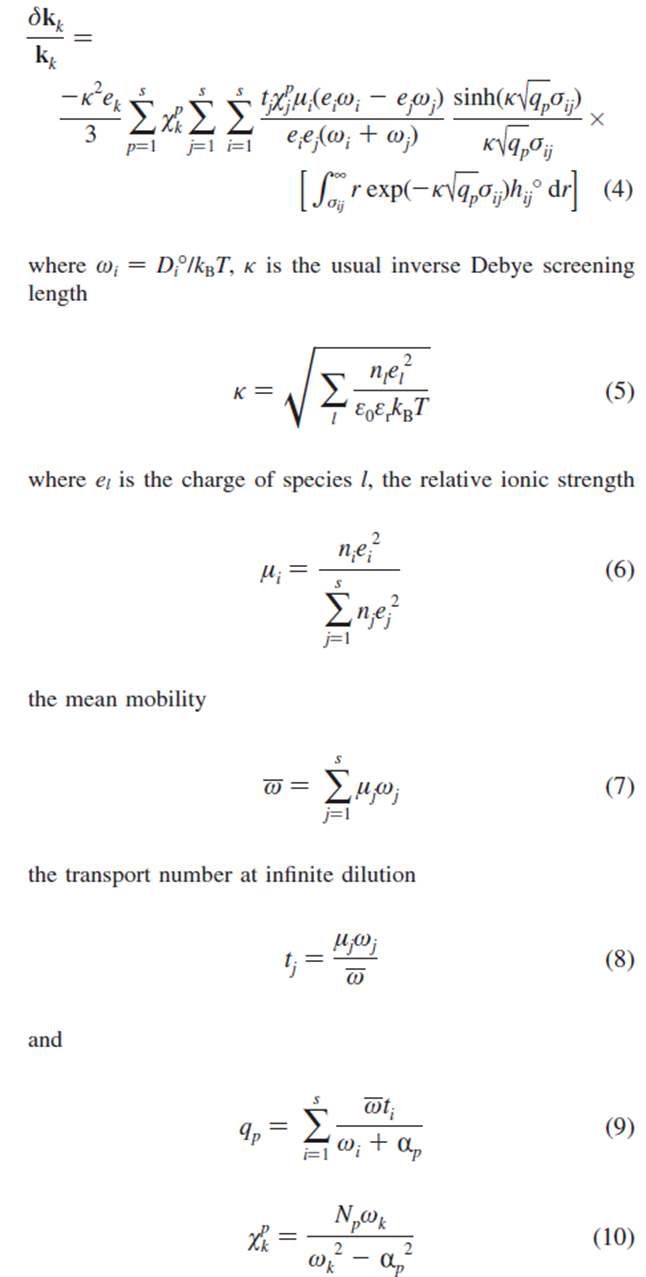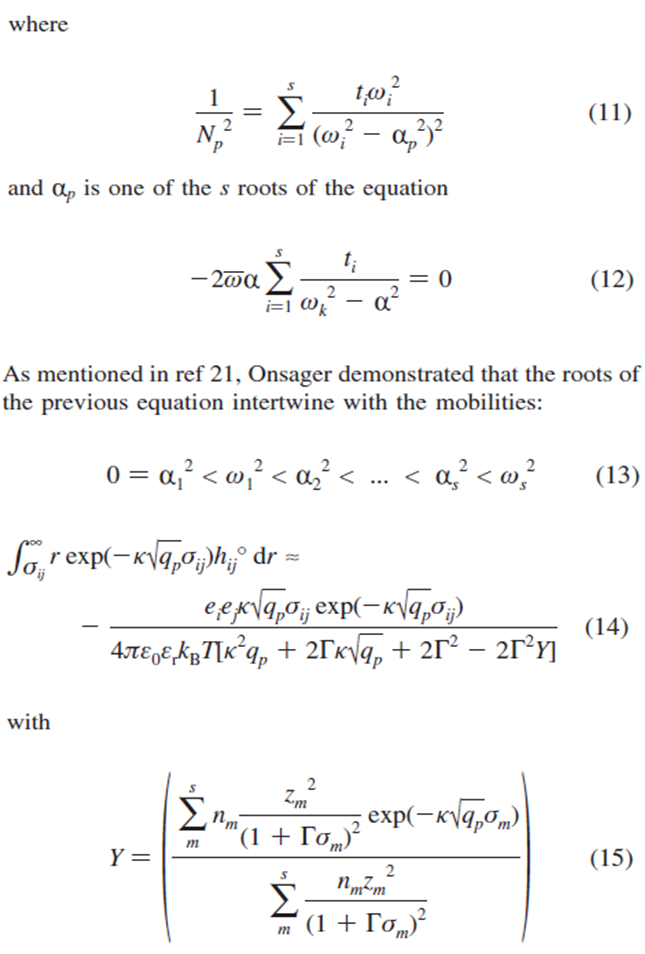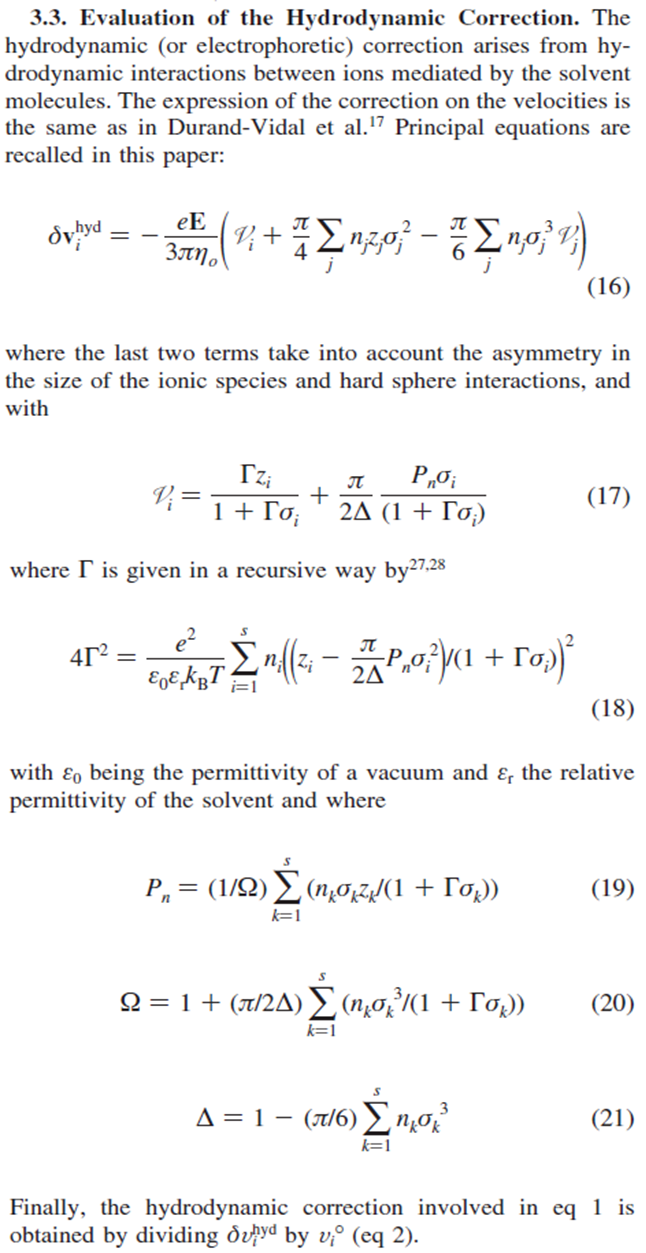

Code implementation

In [594]:
# loading NaCl and CaCl2 experiment data
data = pd.read_csv("./Data/NaCl_CaCl2_interaction.csv")
NaCl_conc = data["NaCl conc"]
CaCl2_conc = data["CaCl2 conc"]
cond_exp = data["Bulk cond"]

# number of data points
ndata = len(cond_exp)

In [595]:
# loading CaCl2 and LaCl3 experiment data
data2 = pd.read_csv("./Data/CaCl2_LaCl3_interaction.csv")
LaCl3_conc = data2["LaCl3 conc"]
CaCl2_conc2 = data2["CaCl2 conc"]
cond_exp2 = data2["Bulk cond"]

# number of data points
ndata2 = len(cond_exp2)

In [596]:
# loading NaCl and MgCl2 experiment data from reference
data3 = pd.read_csv("./Data/NaCl_MgCl2_2.csv")
NaCl_conc2 = data3["NaCl_conc"]
MgCl2_conc = data3["MgCl2_conc"]
molar_cond_exp = data3["Molar_cond"]

# number of data points
ndata3 = len(molar_cond_exp)

In [597]:
# loading NaCl and LaCl3 experiment data
data4 = pd.read_csv("./Data/NaCl_LaCl3_interaction.csv")
NaCl_conc3 = data4["NaCl conc"]
LaCl3_conc2 = data4["LaCl3 conc"]
cond_exp3 = data4["Bulk cond"]

# number of data points
ndata4 = len(cond_exp3)

Equation Parameters and Constants in SI unit

In [598]:
# Avogadro's number
Avogadros_num = 6.022*10**23

# Boltzman constant
k_B = 1.381 * 10**(-23)

# temperature
T = 298.15

# electron charge
charge = 1.602 * 10**(-19)

# diffusion coefficients at infinite dilution
Diff_Na = 1.334 * 10**(-9)
Diff_Cl = 2.032 * 10**(-9)
Diff_Ca = 0.792 * 10**(-9)
Diff_La = 0.619 * 10**(-9)
Diff_Mg = 0.706 * 10**(-9)

# measuring voltage
voltage = 25 * 10**(-3)
distance = 9 * 10**(-6)

# valencies
z_Na = 1
z_Cl = -1
z_Ca = 2
z_La = 3
z_Mg = 2

# hard sphere diameters
sigma_Cl = 2 * 181 * 10**(-12)
sigma_Ca = 2 * 100 * 10**(-12)
sigma_La = 2 * 103.2 * 10**(-12)
sigma_Na = 2 * 102 * 10**(-12)
sigma_Mg = 2 * 72 * 10**(-12)
# sigma_Na = 2 * 117 * 10**(-12)
# sigma_Mg = 2 * 182 * 10**(-12)

# solvent viscosity
eta = 0.89 * 10**(-3)

# electric field
E_field = voltage/distance

# other constants
epsilon = 78.4
epsilon_0 = 8.854 * 10**(-12)

NaCl and CaCl2

In [599]:
# converting molar concentrations to number density
number_density_NaCl = [NaCl_conc[i]*Avogadros_num for i in range(ndata)]
number_density_CaCl2 = [CaCl2_conc[i]*Avogadros_num for i in range(ndata)]

# components list
components = ["Ca", "Na", "Cl"]

# number of species
n_species = len(components)

# valencies
valency = [z_Ca, z_Na, z_Cl]

# species charge
ion_charge = [valency[i]*charge for i in range(len(valency))]

# diffusion coefficients
diff_coeff = [Diff_Ca, Diff_Na, Diff_Cl]

# hard sphere diameters
diameters = [sigma_Ca, sigma_Na, sigma_Cl]

# evaluating number density of individual species
number_density_Na = number_density_NaCl
number_density_Ca = number_density_CaCl2
number_density_Cl = [number_density_NaCl[i] + 2*number_density_CaCl2[i] for i in range(ndata)]

# conductivity
all_cond_calc = np.zeros(ndata)

# for mixture concentration (row) in data
for n in range(ndata):
    # number density of species
    n_Ca = number_density_Ca[n]
    n_Na = number_density_Na[n]
    n_Cl =  number_density_Cl[n]
    number_density = [n_Ca, n_Na, n_Cl]
    
    # ksi matrix
    ksi = np.zeros((n_species, n_species))

    # conductivity of species from equation (1)
    cond_species = np.zeros(n_species)

    # calculating delta from equation (21)
    delta = 1 - ((math.pi/6)*sum(number_density[k]*diameters[k]**3 for k in range(n_species)))

    # evaluating the upper bounds of gamma
    # ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))

    # writing a function that evaluates equation (18)
    def func_gamma(gamma):
        """
        Evaluates residual of equation (18)

        Arguments:
            gamma

        Returns:
            Residual of the equation
        """
        # calculating capital omega from equation (20)
        capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))

        # calculating Pn from equation (19)
        P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))
        # return(4*gamma**2 - ((4*math.pi*(charge**2)/(epsilon*epsilon_0*k_B*T))*
        #        sum(number_density[l]*((valency[l] - (math.pi*P_n*diameters[l]**2/(2*delta)))/(1 + gamma*diameters[l]))**2 for l in range(n_species)))
        #       )
        # return(4*epsilon_0*gamma**2 - ((4*math.pi*(charge**2)/(epsilon*k_B*T))*
        #        sum(number_density[l]*((valency[l] - (math.pi*P_n*diameters[l]**2/(2*delta)))/(1 + gamma*diameters[l]))**2 for l in range(n_species)))
        #       )
        return(4*epsilon_0*gamma**2 - ((charge**2)/(epsilon*k_B*T))*
               sum(number_density[l]*((valency[l] - (math.pi*P_n*diameters[l]**2/(2*delta)))/(1 + gamma*diameters[l]))**2 for l in range(n_species))
              )

    # initial gamma value
    # zeta_1 = sum(number_density[k]*diameters[k] for k in range(n_species))
    # zeta_0 = sum(number_density[k] for k in range(n_species))
    # sigma_bar = zeta_1/zeta_0
    # gamma_initial = (-1 + (1 + 2*ksi_0*sigma_bar)**0.5)/(2*sigma_bar)

    # finding gamma, the root of equation (18)
    # root_func_gamma = fsolve(func_gamma, gamma_initial)
    # gamma = root_func_gamma[0]
    gamma = bisect(func_gamma, 0, 0.5*ksi_0)
    # print(f"Gamma: {gamma}")
    # print(func_gamma(gamma))

    # re-evaluating capital_omega, P_n and nu
    capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))
    P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))

    # nu values for all species from equation (17)
    nu = np.zeros(n_species)
    for k in range(n_species):
        nu[k] = gamma*valency[k]/(1 + gamma*diameters[k]) + (math.pi/(2*delta))*(P_n*diameters[k]/(1 + gamma*diameters[k]))

    # evaluating omega and mew for all species
    omega = np.zeros(n_species)
    mew = np.zeros(n_species)
    for a in range(n_species):
        omega[a] = diff_coeff[a]/(k_B*T) 
        mew[a] = number_density[a]*ion_charge[a]**2/sum(number_density[j]*ion_charge[j]**2 for j in range(n_species))

    # evaluating kappa from equation (5)
    kappa = math.sqrt(sum(number_density[l]*ion_charge[l]**2/(epsilon*epsilon_0*k_B*T) for l in range(n_species)))
    # kappa = math.sqrt(4*math.pi*sum(number_density[l]*ion_charge[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    
    # evaluating the mean mobility, omega_bar from equation (7)
    omega_bar = sum(mew[j]*omega[j] for j in range(n_species))

    # evaluating transport number for all species from equation (8)
    transport_num = np.zeros(n_species)
    for j in range(n_species):
        transport_num[j] = mew[j]*omega[j]/omega_bar

    # evaluating q and N for all species from equation (9) and (11) respectively
    q = np.zeros(n_species)
    N = np.zeros(n_species)
    alpha_scaled = np.zeros(n_species)

    # function that evaluates equation (12)
    def func_alpha(alpha_scaled):
        """ 
        Evaluates residuals of equation 12

        Arguments:
            alpha_scaled = alpha/omega_bar

        Returns:
            residual of the equation
        """
        return((alpha_scaled)*sum(transport_num[k]/((omega[k]/omega_bar)**2 - (alpha_scaled)**2) for k in range(n_species)))
    
    # since alpha is scaled by omega_bar, the bounds (omega), need to be scaled by same factor
    omega_scaled = np.zeros(n_species)
    for k in range(n_species):
        if k == 0:
            omega_scaled[k] = omega[k]/omega_bar
        elif k == 1:
            omega_scaled[k] = omega[k]/omega_bar
        else:
            omega_scaled[k] = omega[k]/omega_bar

    # updating the values of alpha_scaled
    for p in range(n_species):
        if p == 0:
            alpha_scaled[p] = bisect(func_alpha, 0, 0.95*omega_scaled[p])
        elif p == 1:
            alpha_scaled[p] = bisect(func_alpha, 1.05*omega_scaled[p-1], 0.95*omega_scaled[p])
        else:
            alpha_scaled[p] = bisect(func_alpha, 1.05*omega_scaled[p-1], 0.95*omega_scaled[p])

    # rescaling alpha_scaled back to alpha
    alphas = [alpha_scaled[p]*omega_bar for p in range(n_species)]

    # updating q and N values
    for p in range(n_species):
        q[p] = sum(omega_bar*transport_num[r]/(omega[r] + alphas[p]) for r in range(n_species))
        N[p] = math.sqrt(1/sum(transport_num[r]*omega[r]**2/(omega[r]**2 - alphas[p]**2)**2 for r in range(n_species)))
    
    # velocity of species
    vel = np.zeros(n_species)

    # correction on the velocity of species
    delta_vel =  np.zeros(n_species)

    # hydrodynamic correction
    delta_vel_divide_vel = np.zeros(n_species)

    # relaxation correction from equation (4)
    delta_k_divide_k = np.zeros(n_species)
    
    # evaluating hydrodynamic correction term in equation (1)
    for i in range(n_species):
        # updating velocity of species from equation (2)
        vel[i] = valency[i]*charge*E_field*diff_coeff[i]/(k_B*T)

        # updating correction on the velocity of species from equation (16)
        delta_vel[i] = -(charge*E_field/(3*math.pi*eta))*(nu[i] + (math.pi/4)*sum(number_density[j]*valency[j]*diameters[j]**2 for j in range(n_species)) 
                                                           - (math.pi/6)*sum(number_density[j]*(diameters[j]**3)*nu[j] for j in range(n_species)))

        # updating hydrodynamic correction; equation (16) divide equation (2)
        delta_vel_divide_vel[i] = delta_vel[i]/vel[i]

        # evaluating ksi for all species
        for p in range(n_species):
            ksi[i][p] = N[p]*omega[i]/(omega[i]**2 - alphas[p]**2)

    # evaluating the summation term of equation (1) for all species
    for i in range(n_species):
        # evaluating summation term of the relaxation correction in equation (4)
        delta_k_divide_k_sum = 0.0
        for p in range(n_species):
            for j in range(n_species):
                for a in range(n_species):
                    # calculating average diameter
                    # sigma_aj = 0.5*(diameters[a] + diameters[j])
                    sigma_aj = (kappa - (2*gamma))/(2*gamma**2)

                    # first fraction of summation term
                    term1 = transport_num[j]*ksi[j][p]*mew[a]*(ion_charge[a]*omega[a] - ion_charge[j]*omega[j])/(ion_charge[a]*ion_charge[j]*(omega[a] + omega[j]))

                    # second fraction of summation term
                    term2 = math.sinh(kappa*math.sqrt(q[p])*sigma_aj)/(kappa*math.sqrt(q[p])*sigma_aj)

                    # integral numerator from equation (14)
                    # integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*sigma_aj*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)
                    integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)

                    # calculating Y from equation (15)
                    Y_num = sum(number_density[m]*(valency[m]**2)*np.exp(-kappa*math.sqrt(q[p])*diameters[m])/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y_denom = sum(number_density[m]*valency[m]**2/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y = Y_num/Y_denom
                    # Y = (kappa**2)*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)/(2*(1 + gamma*sigma_aj)**2)

                    # integral denominator from equation (14)
                    integral_denom = 4*math.pi*epsilon_0*epsilon*k_B*T*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - 2*(gamma**2)*Y)
                    # integral_denom = epsilon*epsilon_0*k_B*T*((1 + gamma*sigma_aj)**2)*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - Y)
                    delta_k_divide_k_sum += ksi[i][p]*term1*term2*(integral_num/integral_denom)
        
        # relaxation correction from equation (4)
        delta_k_divide_k[i] = -(kappa**2)*ion_charge[i]*delta_k_divide_k_sum/3
        
        # calculating conductivity of species from equation (1)
        cond_species[i] = (charge**2)*number_density[i]*diff_coeff[i]*(valency[i]**2)*(1 + delta_vel_divide_vel[i])*(1 + delta_k_divide_k[i])/(k_B*T)

    # evaluating the conductivity in equation (1)
    all_cond_calc[n] = sum(cond_species)

# converting calculated conductivity in S/m to uS/cm
all_cond_calc_con = [all_cond_calc[i]*10**6/100 for i in range(ndata)]

print(f"Relaxation correction: {delta_k_divide_k}")
print(f"Hydrodynamic correction: {delta_vel_divide_vel}")
print(f"omega_bar: {omega_bar}")
print(f"Alpha: {alphas}")
print(f"Mew: {mew}")
print(f"Transport number: {transport_num}")
print(f"Omega: {omega}")
print(f"ksi: {ksi}")

Relaxation correction: [-0.1413498  -0.05187372 -0.09661176]
Hydrodynamic correction: [-0.28628408 -0.16856384 -0.10617777]
omega_bar: 339141821099.775
Alpha: [0.0, 255235452006.8622, 387504939151.8432]
Mew: [0.4 0.2 0.4]
Transport number: [0.22686909 0.19106273 0.58206818]
Omega: [1.92351992e+11 3.23986816e+11 4.93509152e+11]
ksi: [[ 1.61660646 -1.29858114 -0.32878394]
 [ 0.95978434  1.5459217  -1.38665899]
 [ 0.63009464  0.52562029  1.02211343]]


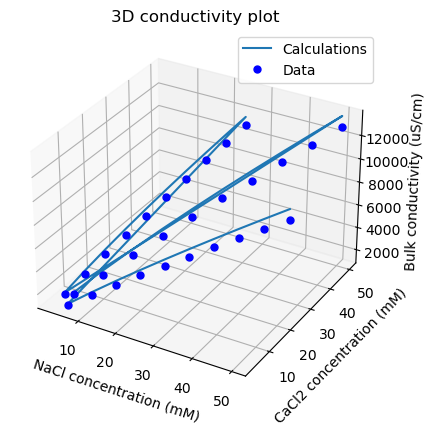

In [600]:
# making plot comparison of calculated and experimental conductivity of NaCl and CaCl2
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plotting
ax.plot3D(NaCl_conc, CaCl2_conc, all_cond_calc_con, label="Calculations")
ax.plot3D(NaCl_conc, CaCl2_conc, cond_exp, "b.", markersize=10, label="Data")
ax.set_title('3D conductivity plot')
ax.set_zlabel("Bulk conductivity (uS/cm)")
ax.set_xlabel("NaCl concentration (mM)")
ax.set_ylabel("CaCl2 concentration (mM)")
ax.legend()
plt.show()

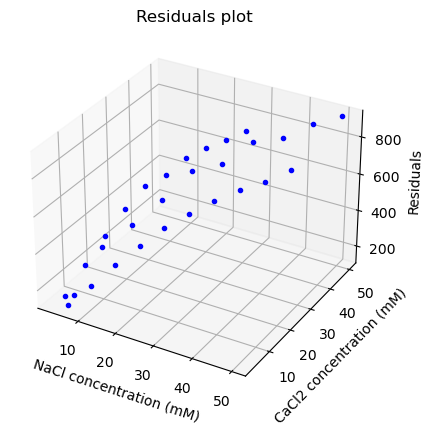

In [601]:
# residuals for NaCl and CaCl2
e = [all_cond_calc_con[i] - cond_exp[i] for i in range(ndata)]

# making plots of residuals
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')

# plotting
ax.plot3D(NaCl_conc, CaCl2_conc, e, "b.")
ax.set_title("Residuals plot")
ax.set_zlabel("Residuals")
ax.set_xlabel("NaCl concentration (mM)")
ax.set_ylabel("CaCl2 concentration (mM)")
plt.show()

CaCl2 and LaCl3

In [602]:
# converting molar concentrations to number density
number_density_LaCl3 = [LaCl3_conc[i]*Avogadros_num for i in range(ndata2)]
number_density_CaCl2_2 = [CaCl2_conc2[i]*Avogadros_num for i in range(ndata2)]

# components list
components = ["La", "Ca", "Cl"]

# number of species
n_species = len(components)

# valencies
valency = [z_La, z_Ca, z_Cl]

# species charge
ion_charge = [valency[i]*charge for i in range(len(valency))]

# diffusion coefficients
diff_coeff = [Diff_La, Diff_Ca, Diff_Cl]

# hard sphere diameters
diameters = [sigma_La, sigma_Ca, sigma_Cl]

# evaluating number density of individual species
number_density_La = number_density_LaCl3
number_density_Ca_2 = number_density_CaCl2_2
number_density_Cl_2 = [3*number_density_LaCl3[i] + 2*number_density_CaCl2_2[i] for i in range(ndata2)]

# conductivity
all_cond_calc = np.zeros(ndata2)

# for mixture concentration (row) in data
for n in range(ndata2):
    # number density of species
    n_Ca = number_density_Ca_2[n]
    n_La = number_density_La[n]
    n_Cl =  number_density_Cl_2[n]
    number_density = [n_La, n_Ca, n_Cl]
    
    # ksi matrix
    ksi = np.zeros((n_species, n_species))

    # conductivity of species from equation (1)
    cond_species = np.zeros(n_species)

    # calculating delta from equation (21)
    delta = 1 - ((math.pi/6)*sum(number_density[k]*diameters[k]**3 for k in range(n_species)))

    # evaluating the upper bounds of gamma
    # ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))

    # writing a function that evaluates equation (18)
    def func_gamma(gamma):
        """
        Evaluates residual of equation (18)

        Arguments:
            gamma

        Returns:
            Residual of the equation
        """
        # calculating capital omega from equation (20)
        capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))

        # calculating Pn from equation (19)
        P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))
        return(4*epsilon_0*gamma**2 - ((charge**2)/(epsilon*k_B*T))*
               sum(number_density[l]*((valency[l] - (math.pi*P_n*diameters[l]**2/(2*delta)))/(1 + gamma*diameters[l]))**2 for l in range(n_species))
              )

    # finding gamma, the root of equation (18)
    gamma = bisect(func_gamma, 0, 0.5*ksi_0)

    # re-evaluating capital_omega, P_n and nu
    capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))
    P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))

    # nu values for all species from equation (17)
    nu = np.zeros(n_species)
    for k in range(n_species):
        nu[k] = gamma*valency[k]/(1 + gamma*diameters[k]) + (math.pi/(2*delta))*(P_n*diameters[k]/(1 + gamma*diameters[k]))

    # evaluating omega and mew for all species
    omega = np.zeros(n_species)
    mew = np.zeros(n_species)
    for a in range(n_species):
        omega[a] = diff_coeff[a]/(k_B*T) 
        mew[a] = number_density[a]*ion_charge[a]**2/sum(number_density[j]*ion_charge[j]**2 for j in range(n_species))

    # evaluating kappa from equation (5)
    kappa = math.sqrt(sum(number_density[l]*ion_charge[l]**2/(epsilon*epsilon_0*k_B*T) for l in range(n_species)))
    # kappa = math.sqrt(4*math.pi*sum(number_density[l]*ion_charge[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    
    # evaluating the mean mobility, omega_bar from equation (7)
    omega_bar = sum(mew[j]*omega[j] for j in range(n_species))

    # evaluating transport number for all species from equation (8)
    transport_num = np.zeros(n_species)
    for j in range(n_species):
        transport_num[j] = mew[j]*omega[j]/omega_bar

    # evaluating q and N for all species from equation (9) and (11) respectively
    q = np.zeros(n_species)
    N = np.zeros(n_species)
    alpha_scaled = np.zeros(n_species)

    # function that evaluates equation (12)
    def func_alpha(alpha_scaled):
        """ 
        Evaluates residuals of equation 12

        Arguments:
            alpha_scaled = alpha/omega_bar

        Returns:
            residual of the equation
        """
        return((alpha_scaled)*sum(transport_num[k]/((omega[k]/omega_bar)**2 - (alpha_scaled)**2) for k in range(n_species)))
    
    # since alpha is scaled by omega_bar, the bounds (omega), need to be scaled by same factor
    omega_scaled = np.zeros(n_species)
    for k in range(n_species):
        if k == 0:
            omega_scaled[k] = omega[k]/omega_bar
        elif k == 1:
            omega_scaled[k] = omega[k]/omega_bar
        else:
            omega_scaled[k] = omega[k]/omega_bar

    # updating the values of alpha_scaled
    for p in range(n_species):
        if p == 0:
            alpha_scaled[p] = bisect(func_alpha, 0, 0.991*omega_scaled[p])
        elif p == 1:
            alpha_scaled[p] = bisect(func_alpha, 1.001*omega_scaled[p-1], 0.991*omega_scaled[p])
        else:
            alpha_scaled[p] = bisect(func_alpha, 1.001*omega_scaled[p-1], 0.991*omega_scaled[p])

    # rescaling alpha_scaled back to alpha
    alphas = [alpha_scaled[p]*omega_bar for p in range(n_species)]

    # updating q and N values
    for p in range(n_species):
        q[p] = sum(omega_bar*transport_num[r]/(omega[r] + alphas[p]) for r in range(n_species))
        N[p] = math.sqrt(1/sum(transport_num[r]*omega[r]**2/(omega[r]**2 - alphas[p]**2)**2 for r in range(n_species)))
    
    # velocity of species
    vel = np.zeros(n_species)

    # correction on the velocity of species
    delta_vel =  np.zeros(n_species)

    # hydrodynamic correction
    delta_vel_divide_vel = np.zeros(n_species)

    # relaxation correction from equation (4)
    delta_k_divide_k = np.zeros(n_species)
    
    # evaluating hydrodynamic correction term in equation (1)
    for i in range(n_species):
        # updating velocity of species from equation (2)
        vel[i] = valency[i]*charge*E_field*diff_coeff[i]/(k_B*T)

        # updating correction on the velocity of species from equation (16)
        delta_vel[i] = -(charge*E_field/(3*math.pi*eta))*(nu[i] + (math.pi/4)*sum(number_density[j]*valency[j]*diameters[j]**2 for j in range(n_species)) 
                                                           - (math.pi/6)*sum(number_density[j]*(diameters[j]**3)*nu[j] for j in range(n_species)))

        # updating hydrodynamic correction; equation (16) divide equation (2)
        delta_vel_divide_vel[i] = delta_vel[i]/vel[i]

        # evaluating ksi for all species
        for p in range(n_species):
            ksi[i][p] = N[p]*omega[i]/(omega[i]**2 - alphas[p]**2)

    # evaluating the summation term of equation (1) for all species
    for i in range(n_species):
        # evaluating summation term of the relaxation correction in equation (4)
        delta_k_divide_k_sum = 0.0
        for p in range(n_species):
            for j in range(n_species):
                for a in range(n_species):
                    # calculating average diameter
                    # sigma_aj = 0.5*(diameters[a] + diameters[j])
                    sigma_aj = (kappa - (2*gamma))/(2*gamma**2)

                    # first fraction of summation term
                    term1 = transport_num[j]*ksi[j][p]*mew[a]*(ion_charge[a]*omega[a] - ion_charge[j]*omega[j])/(ion_charge[a]*ion_charge[j]*(omega[a] + omega[j]))

                    # second fraction of summation term
                    term2 = math.sinh(kappa*math.sqrt(q[p])*sigma_aj)/(kappa*math.sqrt(q[p])*sigma_aj)

                    # integral numerator from equation (14)
                    # integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*sigma_aj*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)
                    integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)

                    # calculating Y from equation (15)
                    Y_num = sum(number_density[m]*(valency[m]**2)*np.exp(-kappa*math.sqrt(q[p])*diameters[m])/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y_denom = sum(number_density[m]*valency[m]**2/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y = Y_num/Y_denom
                    # Y = (kappa**2)*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)/(2*(1 + gamma*sigma_aj)**2)

                    # integral denominator from equation (14)
                    integral_denom = 4*math.pi*epsilon_0*epsilon*k_B*T*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - 2*(gamma**2)*Y)
                    # integral_denom = epsilon*epsilon_0*k_B*T*((1 + gamma*sigma_aj)**2)*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - Y)
                    delta_k_divide_k_sum += ksi[i][p]*term1*term2*(integral_num/integral_denom)
        
        # relaxation correction from equation (4)
        delta_k_divide_k[i] = -(kappa**2)*ion_charge[i]*delta_k_divide_k_sum/3
        
        # calculating conductivity of species from equation (1)
        cond_species[i] = (charge**2)*number_density[i]*diff_coeff[i]*(valency[i]**2)*(1 + delta_vel_divide_vel[i])*(1 + delta_k_divide_k[i])/(k_B*T)

    # evaluating the conductivity in equation (1)
    all_cond_calc[n] = sum(cond_species)

# converting calculated conductivity in S/m to uS/cm
all_cond_calc_con2 = [all_cond_calc[i]*10**6/100 for i in range(ndata2)]

print(f"Relaxation correction: {delta_k_divide_k}")
print(f"Hydrodynamic correction: {delta_vel_divide_vel}")
print(f"omega_bar: {omega_bar}")
print(f"Alpha: {alphas}")
print(f"Mew: {mew}")
print(f"Transport number: {transport_num}")
print(f"Omega: {omega}")
print(f"ksi: {ksi}")

Relaxation correction: [-0.19352081 -0.07961266 -0.16504377]
Hydrodynamic correction: [-0.39702161 -0.31084534 -0.11386719]
omega_bar: 247450799764.53076
Alpha: [0.0, 183329743947.70795, 357686684724.24457]
Mew: [0.6        0.13333333 0.26666667]
Transport number: [0.36452267 0.10364457 0.53183276]
Omega: [1.50335711e+11 1.92351992e+11 4.93509152e+11]
ksi: [[ 1.4476254  -0.67880905 -0.43233384]
 [ 1.1314143   2.82094056 -0.64074538]
 [ 0.44098431  0.11685009  1.29312383]]


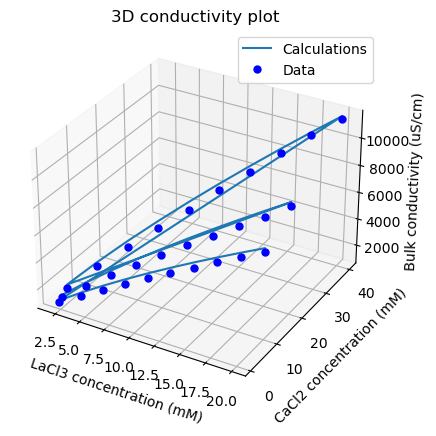

In [603]:
# making plot comparison of calculated and experimental conductivity of CaCl2 and LaCl3
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plotting
ax.plot3D(LaCl3_conc, CaCl2_conc2, all_cond_calc_con2, label="Calculations")
ax.plot3D(LaCl3_conc, CaCl2_conc2, cond_exp2, "b.", markersize=10, label="Data")
ax.set_title('3D conductivity plot')
ax.set_zlabel("Bulk conductivity (uS/cm)")
ax.set_xlabel("LaCl3 concentration (mM)")
ax.set_ylabel("CaCl2 concentration (mM)")
ax.legend()
plt.show()

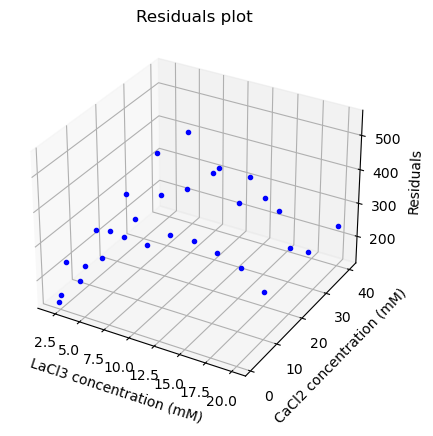

In [604]:
# residuals for CaCl2 and LaCl3
e2 = [all_cond_calc_con2[i] - cond_exp2[i] for i in range(ndata2)]

# making plots of residuals
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')

# plotting
ax.plot3D(LaCl3_conc, CaCl2_conc2, e2, "b.")
ax.set_title("Residuals plot")
ax.set_zlabel("Residuals")
ax.set_xlabel("LaCl3 concentration (mM)")
ax.set_ylabel("CaCl2 concentration (mM)")
plt.show()

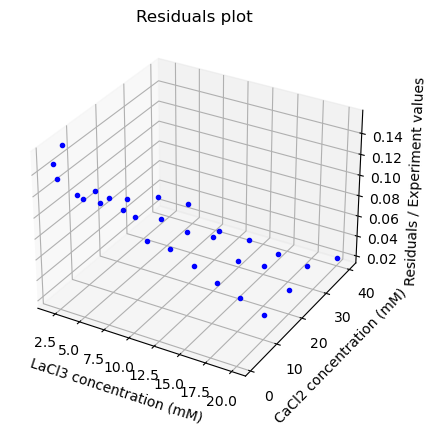

In [614]:
# residuals percent or fraction
residuals_percent2 = [e2[i]/cond_exp2[i] for i in range(ndata2)]

# making plot
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')

# plotting
ax.plot3D(LaCl3_conc2, CaCl2_conc2, residuals_percent2, "b.")
ax.set_title("Residuals plot")
ax.set_zlabel("Residuals / Experiment values")
ax.set_xlabel("LaCl3 concentration (mM)")
ax.set_ylabel("CaCl2 concentration (mM)")
plt.show()

NaCl and LaCl3

In [605]:
# converting molar concentrations to number density
number_density_LaCl3_2 = [LaCl3_conc2[i]*Avogadros_num for i in range(ndata4)]
number_density_NaCl_3 = [NaCl_conc3[i]*Avogadros_num for i in range(ndata4)]

# components list
components = ["La", "Na", "Cl"]

# number of species
n_species = len(components)

# valencies
valency = [z_La, z_Na, z_Cl]

# species charge
ion_charge = [valency[i]*charge for i in range(len(valency))]

# diffusion coefficients
diff_coeff = [Diff_La, Diff_Na, Diff_Cl]

# hard sphere diameters
diameters = [sigma_La, sigma_Na, sigma_Cl]

# evaluating number density of individual species
number_density_La_2 = number_density_LaCl3_2
number_density_Na_3 = number_density_NaCl_3
number_density_Cl_4 = [number_density_NaCl_3[i] + 3*number_density_LaCl3_2[i] for i in range(ndata4)]

# conductivity
all_cond_calc = np.zeros(ndata4)

# for mixture concentration (row) in data
for n in range(ndata4):
    # number density of species
    n_La = number_density_La_2[n]
    n_Na = number_density_Na_3[n]
    n_Cl =  number_density_Cl_4[n]
    number_density = [n_La, n_Na, n_Cl]
    
    # ksi matrix
    ksi = np.zeros((n_species, n_species))

    # conductivity of species from equation (1)
    cond_species = np.zeros(n_species)

    # calculating delta from equation (21)
    delta = 1 - ((math.pi/6)*sum(number_density[k]*diameters[k]**3 for k in range(n_species)))

    # evaluating the upper bounds of gamma
    # ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))

    # writing a function that evaluates equation (18)
    def func_gamma(gamma):
        """
        Evaluates residual of equation (18)

        Arguments:
            gamma

        Returns:
            Residual of the equation
        """
        # calculating capital omega from equation (20)
        capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))

        # calculating Pn from equation (19)
        P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))
        return(4*epsilon_0*gamma**2 - ((charge**2)/(epsilon*k_B*T))*
               sum(number_density[l]*((valency[l] - (math.pi*P_n*diameters[l]**2/(2*delta)))/(1 + gamma*diameters[l]))**2 for l in range(n_species))
              )

    # finding gamma, the root of equation (18)
    gamma = bisect(func_gamma, 0, 0.5*ksi_0)

    # re-evaluating capital_omega, P_n and nu
    capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))
    P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))

    # nu values for all species from equation (17)
    nu = np.zeros(n_species)
    for k in range(n_species):
        nu[k] = gamma*valency[k]/(1 + gamma*diameters[k]) + (math.pi/(2*delta))*(P_n*diameters[k]/(1 + gamma*diameters[k]))

    # evaluating omega and mew for all species
    omega = np.zeros(n_species)
    mew = np.zeros(n_species)
    for a in range(n_species):
        omega[a] = diff_coeff[a]/(k_B*T) 
        mew[a] = number_density[a]*ion_charge[a]**2/sum(number_density[j]*ion_charge[j]**2 for j in range(n_species))

    # evaluating kappa from equation (5)
    kappa = math.sqrt(sum(number_density[l]*ion_charge[l]**2/(epsilon*epsilon_0*k_B*T) for l in range(n_species)))
    # kappa = math.sqrt(4*math.pi*sum(number_density[l]*ion_charge[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    
    # evaluating the mean mobility, omega_bar from equation (7)
    omega_bar = sum(mew[j]*omega[j] for j in range(n_species))

    # evaluating transport number for all species from equation (8)
    transport_num = np.zeros(n_species)
    for j in range(n_species):
        transport_num[j] = mew[j]*omega[j]/omega_bar

    # evaluating q and N for all species from equation (9) and (11) respectively
    q = np.zeros(n_species)
    N = np.zeros(n_species)
    alpha_scaled = np.zeros(n_species)

    # function that evaluates equation (12)
    def func_alpha(alpha_scaled):
        """ 
        Evaluates residuals of equation 12

        Arguments:
            alpha_scaled = alpha/omega_bar

        Returns:
            residual of the equation
        """
        return((alpha_scaled)*sum(transport_num[k]/((omega[k]/omega_bar)**2 - (alpha_scaled)**2) for k in range(n_species)))
    
    # since alpha is scaled by omega_bar, the bounds (omega), need to be scaled by same factor
    omega_scaled = np.zeros(n_species)
    for k in range(n_species):
        if k == 0:
            omega_scaled[k] = omega[k]/omega_bar
        elif k == 1:
            omega_scaled[k] = omega[k]/omega_bar
        else:
            omega_scaled[k] = omega[k]/omega_bar

    # updating the values of alpha_scaled
    for p in range(n_species):
        if p == 0:
            alpha_scaled[p] = bisect(func_alpha, 0, 0.991*omega_scaled[p])
        elif p == 1:
            alpha_scaled[p] = bisect(func_alpha, 1.001*omega_scaled[p-1], 0.991*omega_scaled[p])
        else:
            alpha_scaled[p] = bisect(func_alpha, 1.001*omega_scaled[p-1], 0.991*omega_scaled[p])

    # rescaling alpha_scaled back to alpha
    alphas = [alpha_scaled[p]*omega_bar for p in range(n_species)]

    # updating q and N values
    for p in range(n_species):
        q[p] = sum(omega_bar*transport_num[r]/(omega[r] + alphas[p]) for r in range(n_species))
        N[p] = math.sqrt(1/sum(transport_num[r]*omega[r]**2/(omega[r]**2 - alphas[p]**2)**2 for r in range(n_species)))
    
    # velocity of species
    vel = np.zeros(n_species)

    # correction on the velocity of species
    delta_vel =  np.zeros(n_species)

    # hydrodynamic correction
    delta_vel_divide_vel = np.zeros(n_species)

    # relaxation correction from equation (4)
    delta_k_divide_k = np.zeros(n_species)
    
    # evaluating hydrodynamic correction term in equation (1)
    for i in range(n_species):
        # updating velocity of species from equation (2)
        vel[i] = valency[i]*charge*E_field*diff_coeff[i]/(k_B*T)

        # updating correction on the velocity of species from equation (16)
        delta_vel[i] = -(charge*E_field/(3*math.pi*eta))*(nu[i] + (math.pi/4)*sum(number_density[j]*valency[j]*diameters[j]**2 for j in range(n_species)) 
                                                           - (math.pi/6)*sum(number_density[j]*(diameters[j]**3)*nu[j] for j in range(n_species)))

        # updating hydrodynamic correction; equation (16) divide equation (2)
        delta_vel_divide_vel[i] = delta_vel[i]/vel[i]

        # evaluating ksi for all species
        for p in range(n_species):
            ksi[i][p] = N[p]*omega[i]/(omega[i]**2 - alphas[p]**2)

    # evaluating the summation term of equation (1) for all species
    for i in range(n_species):
        # evaluating summation term of the relaxation correction in equation (4)
        delta_k_divide_k_sum = 0.0
        for p in range(n_species):
            for j in range(n_species):
                for a in range(n_species):
                    # calculating average diameter
                    # sigma_aj = 0.5*(diameters[a] + diameters[j])
                    sigma_aj = (kappa - (2*gamma))/(2*gamma**2)

                    # first fraction of summation term
                    term1 = transport_num[j]*ksi[j][p]*mew[a]*(ion_charge[a]*omega[a] - ion_charge[j]*omega[j])/(ion_charge[a]*ion_charge[j]*(omega[a] + omega[j]))

                    # second fraction of summation term
                    term2 = math.sinh(kappa*math.sqrt(q[p])*sigma_aj)/(kappa*math.sqrt(q[p])*sigma_aj)

                    # integral numerator from equation (14)
                    # integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*sigma_aj*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)
                    integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)

                    # calculating Y from equation (15)
                    Y_num = sum(number_density[m]*(valency[m]**2)*np.exp(-kappa*math.sqrt(q[p])*diameters[m])/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y_denom = sum(number_density[m]*valency[m]**2/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y = Y_num/Y_denom
                    # Y = (kappa**2)*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)/(2*(1 + gamma*sigma_aj)**2)

                    # integral denominator from equation (14)
                    integral_denom = 4*math.pi*epsilon_0*epsilon*k_B*T*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - 2*(gamma**2)*Y)
                    # integral_denom = epsilon*epsilon_0*k_B*T*((1 + gamma*sigma_aj)**2)*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - Y)
                    delta_k_divide_k_sum += ksi[i][p]*term1*term2*(integral_num/integral_denom)
        
        # relaxation correction from equation (4)
        delta_k_divide_k[i] = -(kappa**2)*ion_charge[i]*delta_k_divide_k_sum/3
        
        # calculating conductivity of species from equation (1)
        cond_species[i] = (charge**2)*number_density[i]*diff_coeff[i]*(valency[i]**2)*(1 + delta_vel_divide_vel[i])*(1 + delta_k_divide_k[i])/(k_B*T)

    # evaluating the conductivity in equation (1)
    all_cond_calc[n] = sum(cond_species)

# converting calculated conductivity in S/m to uS/cm
all_cond_calc_con3 = [all_cond_calc[i]*10**6/100 for i in range(ndata4)]

print(f"Relaxation correction: {delta_k_divide_k}")
print(f"Hydrodynamic correction: {delta_vel_divide_vel}")
print(f"omega_bar: {omega_bar}")
print(f"Alpha: {alphas}")
print(f"Mew: {mew}")
print(f"Transport number: {transport_num}")
print(f"Omega: {omega}")
print(f"ksi: {ksi}")

Relaxation correction: [-0.17805457 -0.02049663 -0.15554629]
Hydrodynamic correction: [-0.37468155 -0.17307816 -0.10779429]
omega_bar: 249407449467.97238
Alpha: [0.0, 296713649948.1031, 372366303979.31903]
Mew: [0.69230769 0.03846154 0.26923077]
Transport number: [0.41730337 0.04996255 0.53273408]
Omega: [1.50335711e+11 3.23986816e+11 4.93509152e+11]
ksi: [[ 1.44715366 -0.45169903 -0.31313326]
 [ 0.67150534  3.76294459 -2.32471958]
 [ 0.44084061  0.62394828  1.1373026 ]]


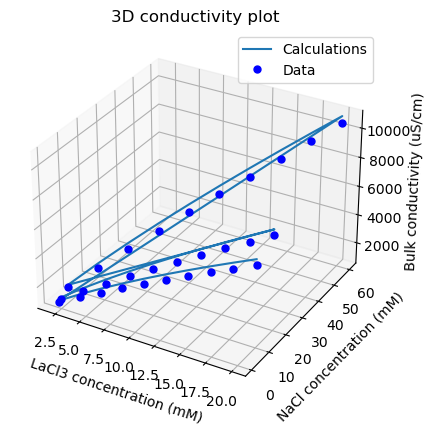

In [606]:
# making plot comparison of calculated and experimental conductivity of NaCl and LaCl3
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# plotting
ax.plot3D(LaCl3_conc2, NaCl_conc3, all_cond_calc_con3, label="Calculations")
ax.plot3D(LaCl3_conc2, NaCl_conc3, cond_exp3, "b.", markersize=10, label="Data")
ax.set_title('3D conductivity plot')
ax.set_zlabel("Bulk conductivity (uS/cm)")
ax.set_xlabel("LaCl3 concentration (mM)")
ax.set_ylabel("NaCl concentration (mM)")
ax.legend()
plt.show()

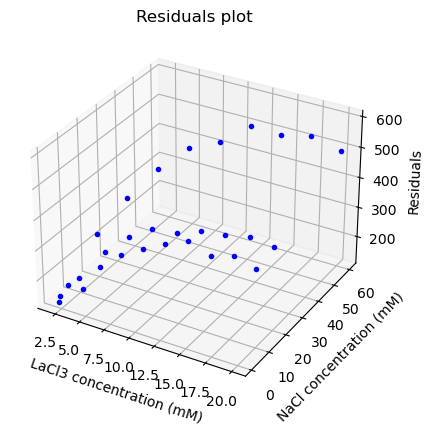

In [607]:
# residuals for NaCl and LaCl3
e3 = [all_cond_calc_con3[i] - cond_exp3[i] for i in range(ndata4)]

# making plots of residuals
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')

# plotting
ax.plot3D(LaCl3_conc2, NaCl_conc3, e3, "b.")
ax.set_title("Residuals plot")
ax.set_zlabel("Residuals")
ax.set_xlabel("LaCl3 concentration (mM)")
ax.set_ylabel("NaCl concentration (mM)")
plt.show()

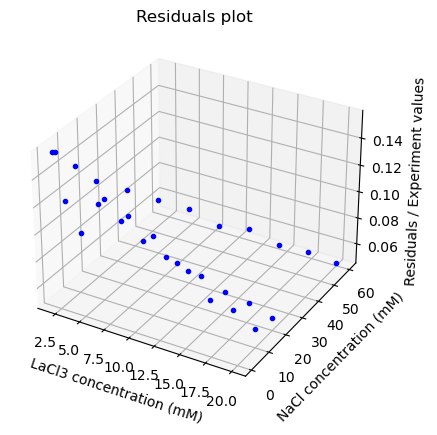

In [613]:
# residuals percent or fraction
residuals_percent3 = [e3[i]/cond_exp3[i] for i in range(ndata4)]

# making plot
fig = plt.figure()
ax = fig.add_subplot(projection ='3d')

# plotting
ax.plot3D(LaCl3_conc2, NaCl_conc3, residuals_percent3, "b.")
ax.set_title("Residuals plot")
ax.set_zlabel("Residuals / Experiment values")
ax.set_xlabel("LaCl3 concentration (mM)")
ax.set_ylabel("NaCl concentration (mM)")
plt.show()

NaCl and MgCl2

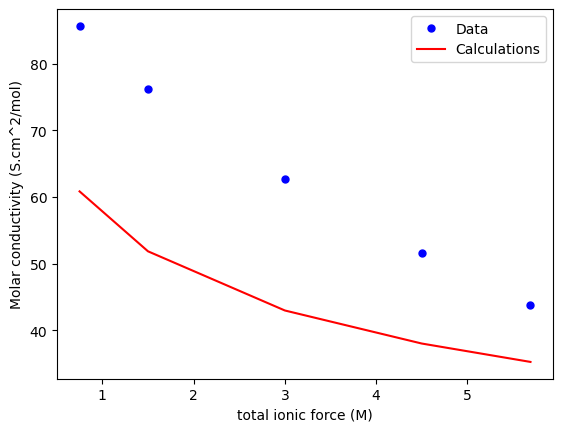

Relaxation correction: [-0.4462763  -0.20759827 -0.30306948]
Hydrodynamic correction: [-1.21409504 -0.54180464 -0.36259994]
Alpha: [0.0, 226945862745.10712, 388739115098.25684]
Mew: [0.33333333 0.25       0.41666667]
Transport number: [0.16625456 0.23560579 0.59813964]
Omega: [1.71465286e+11 3.23986816e+11 4.93509152e+11]


In [608]:
# converting molar concentrations to number density
number_density_MgCl2 = [MgCl2_conc[i]*Avogadros_num for i in range(ndata3)]
number_density_NaCl_2 = [NaCl_conc2[i]*Avogadros_num for i in range(ndata3)]

# components list
components = ["Mg", "Na", "Cl"]

# number of species
n_species = len(components)

# valencies
valency = [z_Mg, z_Na, z_Cl]

# species charge
ion_charge = [valency[i]*charge for i in range(len(valency))]

# diffusion coefficients
diff_coeff = [Diff_Mg, Diff_Na, Diff_Cl]

# hard sphere diameters
diameters = [sigma_Mg, sigma_Na, sigma_Cl]

# evaluating number density of individual species
number_density_Mg = number_density_MgCl2
number_density_Na_2 = number_density_NaCl_2
number_density_Cl_3 = [number_density_NaCl_2[i] + 2*number_density_MgCl2[i] for i in range(ndata3)]

# conductivity
all_cond_calc = np.zeros(ndata3)

# for mixture concentration (row) in data
for n in range(ndata3):
    # number density of species
    n_Mg = number_density_Mg[n]
    n_Na = number_density_Na_2[n]
    n_Cl =  number_density_Cl_3[n]
    number_density = [n_Mg, n_Na, n_Cl]
    
    # ksi matrix
    ksi = np.zeros((n_species, n_species))

    # conductivity of species from equation (1)
    cond_species = np.zeros(n_species)

    # calculating delta from equation (21)
    delta = 1 - ((math.pi/6)*sum(number_density[k]*diameters[k]**3 for k in range(n_species)))

    # evaluating the upper bounds of gamma
    # ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    ksi_0 = math.sqrt(4*math.pi*(charge**2)*sum(number_density[l]*valency[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))

    # writing a function that evaluates equation (18)
    def func_gamma(gamma):
        """
        Evaluates residual of equation (18)

        Arguments:
            gamma

        Returns:
            Residual of the equation
        """
        # calculating capital omega from equation (20)
        capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))

        # calculating Pn from equation (19)
        P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))
        return(4*epsilon_0*gamma**2 - ((charge**2)/(epsilon*k_B*T))*
               sum(number_density[l]*((valency[l] - (math.pi*P_n*diameters[l]**2/(2*delta)))/(1 + gamma*diameters[l]))**2 for l in range(n_species))
              )

    # finding gamma, the root of equation (18)
    gamma = bisect(func_gamma, 0, 0.5*ksi_0)

    # re-evaluating capital_omega, P_n and nu
    capital_omega = 1 + ((math.pi/(2*delta))*sum(number_density[k]*diameters[k]**3/(1 + gamma*diameters[k]) for k in range(n_species)))
    P_n = (1/capital_omega)*sum(number_density[k]*diameters[k]*valency[k]/(1 + gamma*diameters[k]) for k in range(n_species))

    # nu values for all species from equation (17)
    nu = np.zeros(n_species)
    for k in range(n_species):
        nu[k] = gamma*valency[k]/(1 + gamma*diameters[k]) + (math.pi/(2*delta))*(P_n*diameters[k]/(1 + gamma*diameters[k]))

    # evaluating omega and mew for all species
    omega = np.zeros(n_species)
    mew = np.zeros(n_species)
    for a in range(n_species):
        omega[a] = diff_coeff[a]/(k_B*T) 
        mew[a] = number_density[a]*ion_charge[a]**2/sum(number_density[j]*ion_charge[j]**2 for j in range(n_species))

    # evaluating kappa from equation (5)
    kappa = math.sqrt(sum(number_density[l]*ion_charge[l]**2/(epsilon*epsilon_0*k_B*T) for l in range(n_species)))
    # kappa = math.sqrt(4*math.pi*sum(number_density[l]*ion_charge[l]**2 for l in range(n_species))/(epsilon*epsilon_0*k_B*T))
    
    # evaluating the mean mobility, omega_bar from equation (7)
    omega_bar = sum(mew[j]*omega[j] for j in range(n_species))

    # evaluating transport number for all species from equation (8)
    transport_num = np.zeros(n_species)
    for j in range(n_species):
        transport_num[j] = mew[j]*omega[j]/omega_bar

    # evaluating q and N for all species from equation (9) and (11) respectively
    q = np.zeros(n_species)
    N = np.zeros(n_species)
    alpha_scaled = np.zeros(n_species)

    # function that evaluates equation (12)
    def func_alpha(alpha_scaled):
        """ 
        Evaluates residuals of equation 12

        Arguments:
            alpha_scaled = alpha/omega_bar

        Returns:
            residual of the equation
        """
        return((alpha_scaled)*sum(transport_num[k]/((omega[k]/omega_bar)**2 - (alpha_scaled)**2) for k in range(n_species)))
    
    # since alpha is scaled by omega_bar, the bounds (omega), need to be scaled by same factor
    omega_scaled = np.zeros(n_species)
    for k in range(n_species):
        if k == 0:
            omega_scaled[k] = omega[k]/omega_bar
        elif k == 1:
            omega_scaled[k] = omega[k]/omega_bar
        else:
            omega_scaled[k] = omega[k]/omega_bar

    # updating the values of alpha_scaled
    for p in range(n_species):
        if p == 0:
            alpha_scaled[p] = bisect(func_alpha, 0, 0.991*omega_scaled[p])
        elif p == 1:
            alpha_scaled[p] = bisect(func_alpha, 1.001*omega_scaled[p-1], 0.991*omega_scaled[p])
        else:
            alpha_scaled[p] = bisect(func_alpha, 1.001*omega_scaled[p-1], 0.991*omega_scaled[p])

    # rescaling alpha_scaled back to alpha
    alphas = [alpha_scaled[p]*omega_bar for p in range(n_species)]

    # updating q and N values
    for p in range(n_species):
        q[p] = sum(omega_bar*transport_num[r]/(omega[r] + alphas[p]) for r in range(n_species))
        N[p] = math.sqrt(1/sum(transport_num[r]*omega[r]**2/(omega[r]**2 - alphas[p]**2)**2 for r in range(n_species)))
    
    # velocity of species
    vel = np.zeros(n_species)

    # correction on the velocity of species
    delta_vel =  np.zeros(n_species)

    # hydrodynamic correction
    delta_vel_divide_vel = np.zeros(n_species)

    # relaxation correction from equation (4)
    delta_k_divide_k = np.zeros(n_species)
    
    # evaluating hydrodynamic correction term in equation (1)
    for i in range(n_species):
        # updating velocity of species from equation (2)
        vel[i] = valency[i]*charge*E_field*diff_coeff[i]/(k_B*T)

        # updating correction on the velocity of species from equation (16)
        delta_vel[i] = -(charge*E_field/(3*math.pi*eta))*(nu[i] + (math.pi/4)*sum(number_density[j]*valency[j]*diameters[j]**2 for j in range(n_species)) 
                                                           - (math.pi/6)*sum(number_density[j]*(diameters[j]**3)*nu[j] for j in range(n_species)))

        # updating hydrodynamic correction; equation (16) divide equation (2)
        delta_vel_divide_vel[i] = delta_vel[i]/vel[i]

        # evaluating ksi for all species
        for p in range(n_species):
            ksi[i][p] = N[p]*omega[i]/(omega[i]**2 - alphas[p]**2)

    # evaluating the summation term of equation (1) for all species
    for i in range(n_species):
        # evaluating summation term of the relaxation correction in equation (4)
        delta_k_divide_k_sum = 0.0
        for p in range(n_species):
            for j in range(n_species):
                for a in range(n_species):
                    # calculating average diameter
                    # sigma_aj = 0.5*(diameters[a] + diameters[j])
                    sigma_aj = (kappa - (2*gamma))/(2*gamma**2)

                    # first fraction of summation term
                    term1 = transport_num[j]*ksi[j][p]*mew[a]*(ion_charge[a]*omega[a] - ion_charge[j]*omega[j])/(ion_charge[a]*ion_charge[j]*(omega[a] + omega[j]))

                    # second fraction of summation term
                    term2 = math.sinh(kappa*math.sqrt(q[p])*sigma_aj)/(kappa*math.sqrt(q[p])*sigma_aj)

                    # integral numerator from equation (14)
                    # integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*sigma_aj*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)
                    integral_num = -ion_charge[a]*ion_charge[j]*kappa*math.sqrt(q[p])*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)

                    # calculating Y from equation (15)
                    Y_num = sum(number_density[m]*(valency[m]**2)*np.exp(-kappa*math.sqrt(q[p])*diameters[m])/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y_denom = sum(number_density[m]*valency[m]**2/(1 + gamma*diameters[m])**2 for m in range(n_species))
                    Y = Y_num/Y_denom
                    # Y = (kappa**2)*np.exp(-kappa*math.sqrt(q[p])*sigma_aj)/(2*(1 + gamma*sigma_aj)**2)

                    # integral denominator from equation (14)
                    integral_denom = 4*math.pi*epsilon_0*epsilon*k_B*T*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - 2*(gamma**2)*Y)
                    # integral_denom = epsilon*epsilon_0*k_B*T*((1 + gamma*sigma_aj)**2)*((kappa**2)*q[p] + 2*gamma*kappa*math.sqrt(q[p]) + 2*gamma**2 - Y)
                    delta_k_divide_k_sum += ksi[i][p]*term1*term2*(integral_num/integral_denom)
        
        # relaxation correction from equation (4)
        delta_k_divide_k[i] = -(kappa**2)*ion_charge[i]*delta_k_divide_k_sum/3
        
        # calculating conductivity of species from equation (1)
        cond_species[i] = (charge**2)*number_density[i]*diff_coeff[i]*(valency[i]**2)*(1 + delta_vel_divide_vel[i])*(1 + delta_k_divide_k[i])/(k_B*T)

    # evaluating the conductivity in equation (1)
    all_cond_calc[n] = sum(cond_species)

# species concentration in mol/m^3
conc_Na = [NaCl_conc2[i] for i in range(ndata3)]
conc_Mg = [MgCl2_conc[i] for i in range(ndata3)]
conc_Cl = [(NaCl_conc2[i] + 2*MgCl2_conc[i]) for i in range(ndata3)]

# calculating molar conductivity in S.m^2/mol for each row in data
molar_cond_calc = np.zeros(ndata3)
total_ionic_force = np.zeros(ndata3)
# for each row of species concentration
for n in range(ndata3):
    c_Mg = conc_Mg[n]
    c_Na = conc_Na[n]
    c_Cl = conc_Cl[n]
    conc_species = [c_Mg, c_Na, c_Cl]
    total_ionic_force[n] = (1/2)*sum(conc_species[i]*valency[i]**2 for i in range(n_species))

    # # total concentration in mol/m^3
    # total_conc = NaCl_conc2[n] + MgCl2_conc[n]

    # molar conductivity
    molar_cond_calc[n] = all_cond_calc[n]/total_ionic_force[n]
    # molar_cond_calc[n] = all_cond_calc[n]/total_conc

# converting molar conductivity to S.cm^2/mol
molar_cond_calc_conv = [molar_cond_calc[i]*10**4 for i in range(ndata3)]

# converting total ionic force to M
total_ionic_force_conv = [total_ionic_force[i]*10**(-3) for i in range(ndata3)]

# making plot comparison of data and calculated values
plt.plot(total_ionic_force_conv, molar_cond_exp, "b.", markersize=10, label="Data")
plt.plot(total_ionic_force_conv, molar_cond_calc_conv, "r-", label="Calculations")
plt.xlabel("total ionic force (M)")
plt.ylabel("Molar conductivity (S.cm^2/mol)")
plt.legend()
plt.show()

# converting molar conductivity in S.m^2/mol to S.cm^2/mol
# molar_cond_calc_con = [molar_cond_calc[i]*10000 for i in range(ndata3)]

# # making plot comparison of calculated and experimental molar conductivity
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot3D(NaCl_conc2, MgCl2_conc, molar_cond_calc_con, label="Calculations")
# ax.plot3D(NaCl_conc2, MgCl2_conc, molar_cond_exp, "b.", markersize=10, label="Data")
# ax.set_title('3D conductivity plot')
# ax.set_zlabel("Molar conductivity (S.cm^2/mol)")
# ax.set_xlabel("NaCl concentration (mM)")
# ax.set_ylabel("MgCl2 concentration (mM)")
# ax.legend()

# # residuals
# e4 = [molar_cond_calc_con[i] - molar_cond_exp[i] for i in range(ndata3)]

# # making plots of residuals
# fig = plt.figure()
# ax = fig.add_subplot(projection ='3d')
# ax.plot3D(NaCl_conc2, MgCl2_conc, e4, "b.")
# ax.set_title("Residuals plot")
# ax.set_zlabel("Residuals")
# ax.set_xlabel("NaCl concentration (mM)")
# ax.set_ylabel("MgCl2 concentration (mM)")
# plt.show()

print(f"Relaxation correction: {delta_k_divide_k}")
print(f"Hydrodynamic correction: {delta_vel_divide_vel}")
print(f"Alpha: {alphas}")
print(f"Mew: {mew}")
print(f"Transport number: {transport_num}")
print(f"Omega: {omega}")